\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

## (a) {-}

In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = pd.read_csv('marketing.csv')

for col in X.columns:
    if col not in ['age', 'balance']:
        X[col] = X[col].astype("category")

X = pd.get_dummies(X).drop('y_no', axis='columns').rename(columns={'y_yes': 'y'})
y = X.pop('y')

X_tmp, X_final, y_tmp, y_final = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=10)

train_dm = xgb.DMatrix(X_train.values, y_train.values)
test_dm = xgb.DMatrix(X_test.values, y_test.values)

param = {'learning_rate': 0.3, 
         'max_depth': 6,
         'objective': 'binary:logistic', 
         'seed': 0, 
         'eval_metric': 'auc', 
        }

# default_bst = xgb.train(param, train_dm)

cvres = xgb.cv(param, train_dm, 100)
cvres.plot()
plt.show()
cvres['test-auc-mean'].argmax()

# 1. {-}

## (a) {-}

In [1]:
def my_adaboost(X, y, B=10):
    """Implement the adaboost function in my_adaboost

    Inputs:
    X, y: Data produced by get_circle_data()
    B: The number of trees to produce during boosting

    Returns:
    trees: a list of fitted tree objects
    alphas: a numpy array of B alpha values for the trees
    """

    n = X.shape[0]
    # Equal observation weights
    wgts = np.repeat(1/n, n)
    trees = [] # To store your trees.  Use append()
    alphas = np.zeros(B) # To store your alphas

    for b in range(B):
        # Find the next split, according to your current weights.
        # Hint: the returned tree supports predict()
        tree, info = find_split(X, y, wgts)
        
        misclf = (tree.predict(X) != y)
        eb = (wgts*misclf).sum()/wgts.sum()
        alpha = np.log((1-eb)/eb)
        alphas[b] = alpha # new tree's weight
        trees.append(tree) # Store the new tree
        wgts *= np.exp(alpha*misclf) # Update observation weights

    return trees, alphas


def predict_ada(trees, alphas, X, y=None):
    """Calculate predictions for boosted trees from my_adaboost.

    If passed true y values, also computes *running* misclassification error
    across all B.

    Inputs:
    trees: list of trees returned by my_adaboost
    alphas: alpha vector returned by my_adaboost
    X: a data set to make predictions on
    y: the true labels for that data set, in {-1,1}.  If given, running prediction error is computed.

    Outputs: a list containing:
    score: the score for each point (before thresholding)
    preds: the thresholded scores: our guesses at class.
    test_err: a length B vector of misclassification error at each step (1 tree to B trees)
    """

    n = X.shape[0]
    B = len(trees)

    # Initialize a score vector to zero.
    # This will store the ongoing sum alpha_b fhat_b(x) for each point.
    score = np.zeros(n)

    # This will store the misclassification error at each step,
    # so we can see how it changes with the number of trees
    test_err = np.zeros(B)

    for b in range(B):
        # Update your score to include the contribution from tree b
        score += alphas[b]*trees[b].predict(X) # updated score
        preds = np.sign(score) # Make predictions in {-1,1}

        if y is not None:
            # Record the misclassification error for the predictions
            # based on thresholding the current score
            test_err[b] = (y!=preds).mean() # current misclassification error
            
    if y is None:
        return score, preds

    return score, preds, test_err


## (b) {-}

For the following results I've modified the ```draw_boosted_trees``` function to fix the output aspect ratio to 1. 

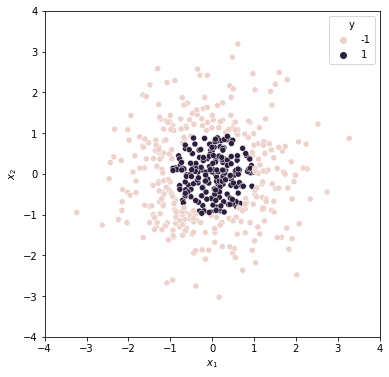

In [2]:
from adaboost_starter_code import *
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

X_train, y_train = get_circle_data(500)
data = DataFrame(X_train, columns=['$x_1$', '$x_2$'])
data['y'] = y_train

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = sns.scatterplot(x='$x_1$', y='$x_2$', hue='y', data=data)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
plt.show()

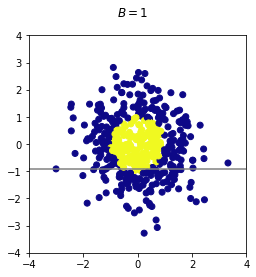

In [5]:
import warnings
warnings.filterwarnings('ignore')

X_train, y_train = get_circle_data(500)
X_test, y_test = get_circle_data(500)

trees, alphas = my_adaboost(X_train, y_train, B=1)
draw_boosted_trees(trees, X_train, y_train)
plt.suptitle('$B=1$')
plt.show()

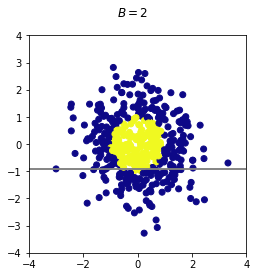

In [6]:
trees, alphas = my_adaboost(X_train, y_train, B=2)
draw_boosted_trees(trees, X_train, y_train)
plt.suptitle('$B=2$')
plt.show()

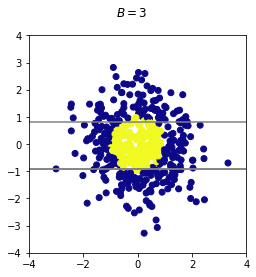

In [7]:
trees, alphas = my_adaboost(X_train, y_train, B=3)
draw_boosted_trees(trees, X_train, y_train)
plt.suptitle('$B=3$')
plt.show()

## (c) {-}

Below we measure the misclassification error as the proportion of misclassified observations, that is the misclassification rate, or $1 - \text{accuracy}$.

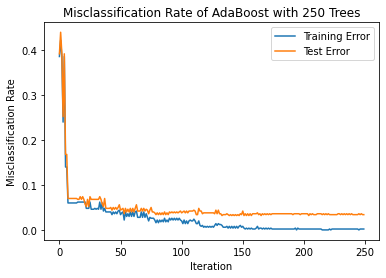

In [11]:
import matplotlib.pyplot as plt
from pandas import DataFrame

trees, alphas = my_adaboost(X_train, y_train, B=250)
err_train = predict_ada(trees, alphas, X_train, y_train)[-1]
err_test = predict_ada(trees, alphas, X_test, y_test)[-1]

pred_err = DataFrame({'Training Error': err_train, 'Test Error': err_test})
ax = pred_err.plot()
ax.set(ylabel='Misclassification Rate', xlabel='Iteration', title='Misclassification Rate of AdaBoost with 250 Trees')
plt.show()

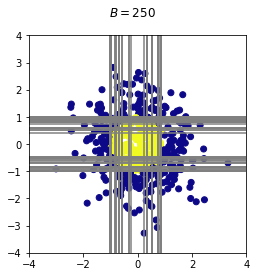

In [12]:
draw_boosted_trees(trees, X_train, y_train)
plt.suptitle('$B=250$')
plt.show()

As the number of trees in boosting goes larger and larger, the misclassified rate on both training and test sets gets smaller and smaller as expected. On the test set, however, the misclassified rate is in general larger than on the training set. 

In [13]:
pred_err

,Training Error,Test Error
0,0.386,0.392
1,0.422,0.440
2,0.386,0.392
3,0.240,0.252
4,0.386,0.392
...,...,...
245,0.000,0.036
246,0.002,0.034
247,0.002,0.036
248,0.002,0.034


## (d) {-}

In [11]:
def calculate_partial_dependence_x1(trees, alphas, X):
    """Calculates the partial dependence plot over the first column of X.

    Fixes the first column at each point in the grid and evaluates the
    predictions at all of these fake points.  These predictions are used
    to obtain the partial dependence over x1.

    Inputs:
    trees: list of trees returned by my_adaboost
    alphas: list of alphas returned by my_adaboost
    X: data set to use for computing partial dependence.
    """

    m = 50 # Number of grid points to evaluate partial dependence
    x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), m)

    # Somewhere to store the partial dependence values
    pdep = np.zeros(m)
    
    # We will fake a dataset and change its x1 values to match each evaluation points
    fake = X.copy()
    for i in range(m):
        fake[:,0] = x[i]
        # dependence at x[i] below
        # HINT: Evaluate predict_ada on the fake data set and use
        # resulting predictions
        pdep[i] = predict_ada(trees, alphas, fake)[1].mean()
        
    return x, pdep


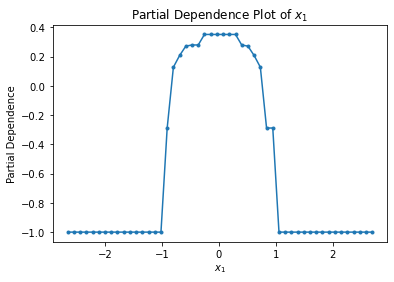

In [9]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

X, y = get_circle_data(500)
trees, alphas = my_adaboost(X, y, B=250)
ax = DataFrame(np.array(calculate_partial_dependence_x1(trees, alphas, X)).T, columns=['$x_1$', 'Partial Dependence']).set_index('$x_1$').plot(style='.-', legend=None)
ax.set(ylabel='Partial Dependence', title='Partial Dependence Plot of $x_1$')
plt.show()


# 2. {-}

## (a) {-}

Using the default settings from ```xgboost```, the MAE is 37,227 as shown below

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

X = pd.read_csv('housing_data.csv')
y = X.pop('median_house_value')

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_final, y_test, y_final = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=10)

train_dm = xgb.DMatrix(X_train.values, y_train.values)
test_dm = xgb.DMatrix(X_test.values, y_test.values)

param = {'learning_rate': 0.3,
        'max_depth': 6,
        }

default_bst = xgb.train(param, train_dm)
mean_absolute_error(y_test, default_bst.predict(test_dm))

37227.1129562867

## (b) {-}

A random forest with 500 trees gives a lower MAE of 32,242. 

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500).fit(X_train, y_train)
mean_absolute_error(y_test, rf.predict(X_test))

32242.374774651333

## (c) {-}

We cross-validate to tune number of trees for boosting. As the number of trees goes up, the training error will become smaller and smaller, but not the test error. The test error is optimized with 157 trees. 

Running the boosting again, this time with 157 trees, we obtain a better MAE of 32,289.88, which is comparable to the previous random forest result. From now on we will be using 157 trees for boosting. 

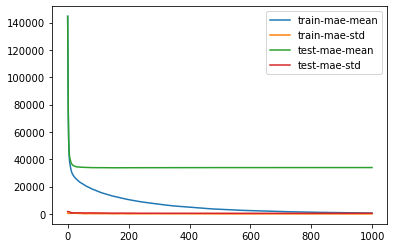

157

In [6]:
import matplotlib.pyplot as plt

param2 = param.copy()
param2['eval_metric'] = 'mae'
cvres2 = xgb.cv(param2, train_dm, 1000)
cvres2.plot()
plt.show()
cvres2['test-mae-mean'].argmin()

In [9]:
# best_rounds2 = cvres2['test-mae-mean'].argmin()
best_rounds2 = 157

best_rounds_bst = xgb.train(param, train_dm, best_rounds2)
mean_absolute_error(y_test, best_rounds_bst.predict(test_dm))

32289.880498092276

## (d) {-}

The ```GridSearchCV``` results suggest that the best parameter combination is ```max_depth=6```, ```min_child_weight=4```, which gives an MAE of 32,782.68 on test data, slightly larger than the MAE by the default model with 157 trees, but still comparable. ```GridSearchCV``` only cross-validates the models on the training data. It is entirely possible the winning model does not have absolutely the best performance on test data. 

In [19]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV 

xgbr = XGBRegressor(
    learning_rate=0.3,
    max_depth=6,
    n_estimators=best_rounds2
)

param_grid1 = {
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 4, 8, 16]
}

grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid1, 
                           scoring='neg_mean_absolute_error', cv=5).fit(X_train, y_train)

grid_search.cv_results_

{'mean_fit_time': array([ 4.83377557,  3.58185143,  3.6831399 ,  3.40728321,  8.17533979,
         7.23451414,  7.58180165, 15.71277399, 64.54760013, 12.28485494,
        13.32903056, 11.08622217, 33.17784233, 16.77140188, 25.22107754,
        17.31368308]),
 'std_fit_time': array([ 2.57937122,  0.20769259,  0.26208578,  0.10625658,  0.80566345,
         0.45762707,  0.67875761,  6.63881974, 48.96747027,  1.02095481,
         1.40305437,  0.90418258, 10.83595443,  0.86290561, 20.45664395,
         4.47862529]),
 'mean_score_time': array([0.02265778, 0.05594063, 0.0538414 , 0.05362639, 0.02257147,
        0.08483014, 0.03706765, 0.08621035, 0.0159112 , 0.01244292,
        0.03747973, 0.05271144, 0.06341543, 0.08573194, 0.03707542,
        0.04651265]),
 'std_score_time': array([0.03712505, 0.04292565, 0.04101208, 0.04088995, 0.03568937,
        0.0899067 , 0.02633173, 0.11093532, 0.01151148, 0.01251009,
        0.03608497, 0.04708804, 0.09232677, 0.07685349, 0.02213967,
        0.054425

In [13]:
from xgboost.sklearn import XGBRegressor

xgbr = XGBRegressor(
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=4, 
    n_estimators=best_rounds2
)

grid_bst = xgbr.fit(X_train, y_train)
mean_absolute_error(y_test, grid_bst.predict(X_test))

32782.684518939626

## (e) {-} 

We run a ```RandomizedSearchCV``` on a large set of parameter combinations. The resulting optimal model is with
```
    subsample = 1,
    min_child_weight = 4,
    max_depth = 9,
    gamma = 10,
    eta = 0.1,
    colsample_bylevel = 1,
```
We then fit the boosting with this set of parameters and obtain an MAE of 32,140 on test data. 

In [30]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgbr = XGBRegressor(
    learning_rate=0.3,
    n_estimators=best_rounds2
)

param_grid2 = {
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 4, 8, 16],
    'eta': [0.05, 0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 10, 100, 1000],
    'subsample': [0.1, 0.3, 0.5, 1],
    'colsample_bylevel': [0.5, 0.7, 1]
}

rand_search = RandomizedSearchCV(estimator=xgbr, param_distributions=param_grid2, n_iter=16, 
                           scoring='neg_mean_absolute_error', cv=5).fit(X_train, y_train)

rand_search.cv_results_

{'mean_fit_time': array([ 5.49598603, 30.32930951, 13.91247902, 21.02537069, 12.73469815,
         7.81802311,  5.27408919,  9.85230985, 11.62441154, 18.23794131,
        11.39701495,  4.12793269,  2.56339068,  3.38862982,  9.53561835,
         5.04352589]),
 'std_fit_time': array([ 0.76570591, 21.75256308,  8.74126264,  9.14695266,  6.31756338,
         0.13784867,  0.27274695,  0.64821558,  2.89250213,  8.88799123,
         4.27878605,  0.66798209,  0.63773509,  0.26105214,  0.33467549,
         0.47606664]),
 'mean_score_time': array([0.13446813, 0.05295691, 0.10801878, 0.17273326, 0.14399085,
        0.04034467, 0.12495775, 0.14556251, 0.16657825, 0.08246274,
        0.10069013, 0.11223812, 0.05679765, 0.08953037, 0.02403989,
        0.07473435]),
 'std_score_time': array([0.1692783 , 0.02799195, 0.11594949, 0.10374717, 0.13906981,
        0.02538138, 0.12924538, 0.13790093, 0.17228092, 0.13416814,
        0.1320479 , 0.03537612, 0.04002082, 0.07675522, 0.02047609,
        0.090786

In [14]:
from xgboost.sklearn import XGBRegressor

xgbr = XGBRegressor(
    subsample=1,
    min_child_weight=4,
    max_depth=9,
    gamma=10,
    eta=0.1,
    colsample_bylevel=1, 
    
    learning_rate=0.3,
    n_estimators=best_rounds2
)

rand_bst = xgbr.fit(X_train, y_train)
mean_absolute_error(y_test, rand_bst.predict(X_test))

32140.225263244167

## (f) {-}

We kept a final test set in the beginning. Now we run all the models considered so far on both test set the and the final test set. The results are summarized below. 

The default boosting model has the worst performance, but after tuning the number of trees we see significant improvement. The randomized search seems to be promising as the optimal model selected beats random forest in MAE on both test set and final test set. 

In [21]:
from pandas import DataFrame

models = {
    'Random Forest': rf, 
    'Boosting Default': default_bst,
    'Boosting with 157 Trees': best_rounds_bst, 
    'Boosting Optimized by Grid Search': grid_bst, 
    'Boosting Optimized by Randomized Search': rand_bst
}

test_dm = xgb.DMatrix(X_test.values, y_test.values)
final_dm = xgb.DMatrix(X_final.values, y_final.values)

mae = []

for model_name, model in models.items():
    try: 
        mae.append((model_name, 
                    mean_absolute_error(y_test, model.predict(X_test)), 
                    mean_absolute_error(y_final, model.predict(X_final))))
    except:
        mae.append((model_name, 
                    mean_absolute_error(y_test, model.predict(test_dm)), 
                    mean_absolute_error(y_final, model.predict(final_dm))))
        
DataFrame(mae, columns=['Model', 'MAE on Test Set', 'MAE on Final Test Set']).set_index('Model')

,MAE on Test Set,MAE on Final Test Set
Model,,
Random Forest,32242.374775,32243.352632
Boosting Default,37227.112956,36504.233825
Boosting with 157 Trees,32289.880498,32084.366628
Boosting Optimized by Grid Search,32782.684519,32343.498163
Boosting Optimized by Randomized Search,32140.225263,32171.692982
